In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (2, 4),
        (2, 8),
        (3, 4),
        (3, 8),
        (4, 4),
    ]:
        for BLOCK_SIZE_M in [32, 64, 128]:#, 128]:
            for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                for BLOCK_SIZE_K in [16, 32]:#[16, 32]:
                    configs.append(
                        triton.Config(
                            {
                                "GROUP_SIZE_M" : 8,
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            }, 
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )                        
    return configs

    # return [triton.Config(
    #                             {
    #                                 "GROUP_SIZE_M" : 8,
    #                                 "BLOCK_SIZE_M" : 16,
    #                                 "BLOCK_SIZE_N" : 16,
    #                                 "BLOCK_SIZE_K" : 16,
    #                             },
    #                             num_stages=2, 
    #                             num_warps=4
    #                         )]

In [3]:
@triton.autotune(
    configs=[
        triton.Config(
            {
                "GROUP_SIZE_M" : 8,
                "BLOCK_SIZE_M" : 64,
                "BLOCK_SIZE_N" : 128,
                "BLOCK_SIZE_K" : 16,
            },
            num_stages=2, 
            num_warps=4
        )
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_fp16(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 2) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        b = b.to(tl.float16)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1] * 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_fp16[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [4]:
@triton.autotune(
    # configs=_get_cuda_autotune_config(),
    configs=[
        triton.Config(
            {
                "GROUP_SIZE_M" : 8,
                "BLOCK_SIZE_M" : 128,
                "BLOCK_SIZE_N" : 128,
                "BLOCK_SIZE_K" : 16,
            },
            num_stages=4, 
            num_warps=4
        )
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_int4_fp16_scaled(
        scales_ptr,
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    scales_ptrs = scales_ptr + pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)

    # For bits unpack
    shifter = tl.arange(0, 2) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        
        scales = tl.load(scales_ptrs)
        b = b.to(tl.float16) * scales[None, :]

        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16_scaled(a, b, scales):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1] * 2
    
    assert list(scales.shape) == [N,]
    assert scales.dtype == torch.float16
    
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_int4_fp16_scaled[grid](
        scales,
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [5]:
@triton.autotune(
    # configs=_get_cuda_autotune_config(),
    configs=[
        triton.Config(
            {
                "GROUP_SIZE_M" : 8,
                "BLOCK_SIZE_M" : 64,
                "BLOCK_SIZE_N" : 128,
                "BLOCK_SIZE_K" : 16,
            },
            num_stages=2, 
            num_warps=4
        )
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_int2_fp16(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 4) + tl.arange(0, BLOCK_SIZE_N // 4)) % (N // 4)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 4) * 2
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0x3
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x2
        b = b.to(tl.float16)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int2_fp16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1] * 4
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_int2_fp16[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [6]:
@triton.autotune(
    configs=[
        triton.Config(
            {
                "GROUP_SIZE_M" : 8,
                "BLOCK_SIZE_M" : 64,
                "BLOCK_SIZE_N" : 128,
                "BLOCK_SIZE_K" : 16,
            },
            num_stages=4,
            num_warps=4
        )
    ],
    # configs=_get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_fp16_bigpack(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 8) + tl.arange(0, BLOCK_SIZE_N // 8)) % (N // 8)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 8) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        b = b.to(tl.float16)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp16_bigpack(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] * 8
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_fp16_bigpack[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [7]:
@triton.autotune(
    configs=[
        triton.Config(
            {
                "GROUP_SIZE_M" : 8,
                "BLOCK_SIZE_M" : 64,
                "BLOCK_SIZE_N" : 64,
                "BLOCK_SIZE_K" : 16,
            },
            num_stages=2, 
            num_warps=4
        )
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_fp32(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 2) + tl.arange(0, BLOCK_SIZE_N // 2)) % (N // 2)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 2) * 4
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)        
        b_bits = tl.load(b_ptrs) #, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N) - 0x8
        b = b.to(tl.float32)
        
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator # .to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_int4_fp32(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float32
    assert b.dtype == torch.int8

    M, K = a.shape
    N = b.shape[1] * 2
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float32)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_fp32[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [8]:
def decode_int8_to_int4(bits):
    v1 = (bits >> 4) & 0xF
    v0 = bits & 0xF

    w = torch.stack([v0, v1], dim=-1) - 0x8
    return w.reshape(bits.shape[0], bits.shape[1] * 2)


def decode_int8_to_int2(bits):
    v3 = (bits >> 6) & 0x3
    v2 = (bits >> 4) & 0x3
    v1 = (bits >> 2) & 0x3
    v0 = bits & 0x3

    w = torch.stack([v0, v1, v2, v3], dim=-1) - 0x2
    return w.reshape(bits.shape[0], bits.shape[1] * 4)


def decode_int32_to_int4(bits):
    v0 = bits & 0xF
    v1 = (bits >> 4) & 0xF
    v2 = (bits >> 8) & 0xF
    v3 = (bits >> 12) & 0xF
    v4 = (bits >> 16) & 0xF
    v5 = (bits >> 20) & 0xF
    v6 = (bits >> 24) & 0xF
    v7 = (bits >> 28) & 0xF
    
    w = torch.stack([v0, v1, v2, v3, v4, v5, v6, v7], dim=-1) - 0x8
    return w.reshape(bits.shape[0], bits.shape[1] * 8)



# torch.manual_seed(0)

# M, N, K = 3 * (4096,)
# M, N, K = 3 * (1024,)
# M, N, K = 3 * (16,)

# y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
# x_compressed = torch.randint(-128, 128, (K, N // 2), dtype=torch.int8, device="cuda")
# x_decompressed = decode_int8_to_int4(x_compressed)

# o1 = torch.matmul(y, x_decompressed.to(torch.float16)
#                   )
# o2 = triton_matmul_int4_fp16(y, x_compressed)
# print(matmul_kernel_fp16.best_config)
# # assert torch.all(torch.isclose(o1, o2))

# o3 = triton_matmul_int4_fp32(y.float(), x_compressed)
# print(matmul_kernel_fp32.best_config)
# # assert torch.all(torch.isclose(o1, o3))

# x_compressed_32bit = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda")
# x_decompressed = decode_int32_to_int4(x_compressed_32bit)

# o3 = triton_matmul_int4_fp16_bigpack(y, x_compressed_32bit)
# print(matmul_kernel_fp16_bigpack.best_config)

# x_compressed = torch.randint(-128, 128, (K, N // 4), dtype=torch.int8, device="cuda")
# x_decompressed = decode_int8_to_int2(x_compressed)

# o1 = torch.matmul(y, x_decompressed.to(torch.float16))
# o2 = triton_matmul_int2_fp16(y, x_compressed)
# print(matmul_kernel_int2_fp16.best_config)


# x_compressed = torch.randint(-128, 128, (K, N // 2), dtype=torch.int8, device="cuda")
# scales = torch.abs(torch.randn(N, dtype=torch.float16, device="cuda"))
# o2 = triton_matmul_int4_fp16_scaled(y, x_compressed, scales)
# print(matmul_kernel_int4_fp16_scaled.best_config)

matmul-performance:
         M       N       K  int2_fp16  int4_fp16_scaled
0   4096.0   512.0   512.0   1.983855          1.826837
1   8192.0  1024.0  1024.0   2.473057          2.391737
2  16384.0  2048.0  2048.0   2.294672          2.250390
3  32768.0  4096.0  4096.0   2.301487          2.297541


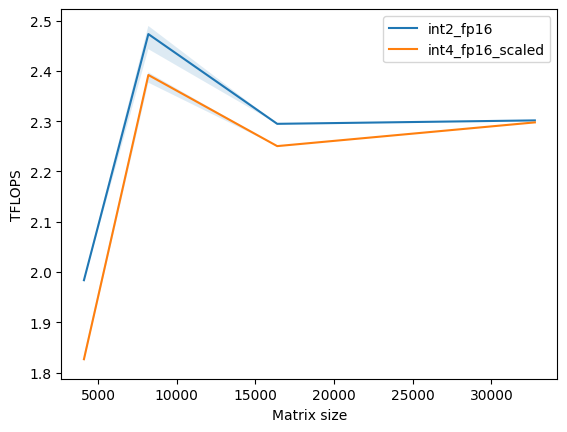

In [9]:
BS = 8
sizes = [512, 1024, 2048, 4096] #, 8192]
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
        x_vals=[(BS * size, size, size) for size in sizes],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[
            # "torch_fp32", 
            # "torch_fp16", 
            "triton_int2_fp16",
            # "triton_int4_fp16",
            "triton_int4_fp16_scaled",
            # "triton_int4_fp16_bigpack",
            # "triton_int4_fp32",
            ],  # Label name for the lines
        line_names=[
            # "torch_fp32", 
            # "torch_fp16", 
            "int2_fp16",
            # "int4_fp16", 
            "int4_fp16_scaled", 
            # "int4_fp16_bigpack",
            # "int4_fp32", 
            ],  # Line styles
        #styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda").contiguous() / (M * K)
    # y_fp32 = torch.randn(M, K, dtype=torch.float32, device="cuda").contiguous() / (M * K)

    x_compressed_int2 = torch.randint(-128, 128, (K, N // 4), dtype=torch.int8, device="cuda").contiguous()
    x_compressed_int4 = torch.randint(-128, 128, (K, N // 2), dtype=torch.int8, device="cuda").contiguous()
    # x_compressed_int4_bigpack = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda").contiguous()
    # x_decompressed_fp16 = decode_int8_to_int4(x_compressed_int4).reshape(K, N).to(torch.float16).contiguous()
    # x_decompressed_fp32 = decode_int8_to_int4(x_compressed_int4).reshape(K, N).to(torch.float32).contiguous()
    scales = torch.abs(torch.randn(N, dtype=torch.float16, device="cuda"))


    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp32":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp32, x_decompressed_fp32), quantiles=quantiles)
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_decompressed_fp16), quantiles=quantiles)
    if provider == "triton_int2_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int2_fp16(y_fp16, x_compressed_int2), quantiles=quantiles)
    if provider == "triton_int4_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16(y_fp16, x_compressed_int4), quantiles=quantiles)
    if provider == "triton_int4_fp16_scaled":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16_scaled(y_fp16, x_compressed_int4, scales), quantiles=quantiles)
    if provider == "triton_int4_fp16_bigpack":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp16_bigpack(y_fp16, x_compressed_int4_bigpack), quantiles=quantiles)
    # if provider == "triton_int4_fp32":
    #     ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_int4_fp32(y_fp32, x_compressed), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)